In [25]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.cluster import KMeans as KMeans_

from scipy import stats
from scipy.spatial import distance

import math
import random

np.random.seed(666)

In [30]:
def euclidean(x1, x2, axis=0):
    return np.abs(np.sqrt(np.sum((x1 - x2)**2, axis=axis)))

def covar_matrix_(x):
    mean = np.mean(x, axis=0)
    x_mean = x - mean

    covar = (np.transpose(x_mean) @ x_mean) / x.shape[0]

    return covar

def inverse_cov(covar):
    return np.linalg.inv(covar)

def mahalanobis(x1, x2, covar):
    inv_covar = np.linalg.inv(covar)

    return math.sqrt(np.sum((x1 - x2).T @ inv_covar @ (x1 - x2)))

def rec_error(K, C):
    sum = 0
    for k in range(K):
        for xi in C[k]:
            mk = np.mean(C[k])
            sum += euclidean(xi, mk)
    return sum

def db_index(X, y_pred):
    K = len(np.bincount(y_pred))
    cluster_k = [X[y_pred == k] for k in range(K)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    within_cluster_scatter = [np.mean([euclidean(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for k in range(K):
        db_kk = []
        for k_ in range(K):
            if k_ != k:
                between_cluster_distance = euclidean(centroids[k], centroids[k_])
                eq = (within_cluster_scatter[k] + within_cluster_scatter[k_]) / between_cluster_distance
                db_kk.append(eq)
        db.append(max(db_kk))

    return np.mean(db)

class KMeans:    
    def __init__(self, n_clusters=4, distance_function='euclidean', inv_covar=None):
        self.K = n_clusters
        self.distance_function = distance_function
        self.X = None
        self.inv_covar = None
        self.distances = ['euclidean', 'mahalanobis']

        if distance_function not in self.distances:
            raise ValueError("Função de Distancia: %s" % (', '.join(self.distances)))
        
        if distance_function == 'mahalanobis':
            if inv_covar is None:
                raise ValueError("Adicionar Matriz Inversa")
            self.inv_covar = inv_covar
        
    def fit(self, X):
        self.X = X
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.intial_centroids = self.centroids
        self.prev_label, self.labels = None, np.zeros(len(X))
        while not np.all(self.labels == self.prev_label):
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def predict(self, X):
        return np.apply_along_axis(self.classify, 1, X)

    def classify(self, x):
        if self.distance_function == 'euclidean':
            return np.argmin(euclidean(self.centroids, x, axis=1))
        elif self.distance_function == 'mahalanobis':
            return np.argmin([mahalanobis(centroid, x, self.inv_covar) for centroid in self.centroids])
        else: 
            return None

    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])

class Data:
    def __init__(self, dataset, features, output):
        self.dataset = dataset
        self.features = features
        self.output = output

    def get_n(self):
        return self.dataset.shape[0]

    def get_x(self):
        return self.dataset[:, self.features]
    
    def get_x_apply(self, func):
        return func(self.dataset[:, self.features])

    def set_x(self, new_x):
        self.x = new_x

    def get_y(self):
        return self.dataset[:, self.output]

    def get_X(self, func=None):
        if (func):
            return np.c_[np.ones(self.get_n()), func(self.get_x())]
        else:
            return np.c_[np.ones(self.get_n()), self.get_x()]

In [5]:
quake = np.genfromtxt('./quake.csv', delimiter=',')

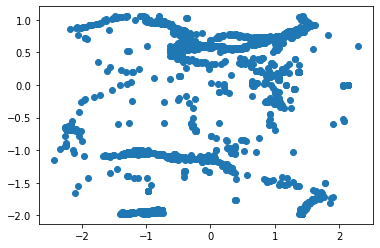

In [42]:
dataset = Data(quake, [0, 1], 0)
X_ = dataset.get_x_apply(func=stats.zscore)

plt.scatter(X_[:,0], X_[:,1])
plt.show()

#models = []
mod = []

for K in range(4, 21):
    b_re = None
    b_mod = None

    for _ in range(20):
        kmeans = KMeans(K)
        kmeans.fit(X_)
        rec_error_ = rec_error(K, kmeans.centroids)
        if b_re is None or rec_error_ < b_re:
            b_re = rec_error_
            b_mod = kmeans
    
    mod.append({'K': K, 'KMeans': b_mod})

best_K = None
best_mod = None
best_db_index = None

for model in mod:
    y_pred = model['KMeans'].predict(X_)
    model_db_index = db_index(X_, y_pred)

    if best_db_index is None or model_db_index < best_db_index:
        best_K = model['K']
        best_mod = model['KMeans']
        best_db_index = model_db_index

y_pred = best_mod.predict(X_)

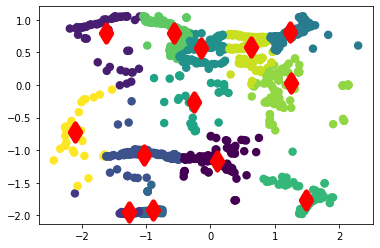

------------------------------
Euclidean Distance
O melhor K é: 13
O melhor DB_Index é: 0.61831
O melhor REC_ERROR é: 13.84858
------------------------------


In [43]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_pred, s=30, linewidths=3)
for centroid in best_mod.centroids:
    plt.scatter(centroid[0], centroid[1], marker="d", color="#FF0000", s=150, linewidths=5)
plt.show()

print("-" * 30)
print('Euclidean Distance')
print("O melhor K é: %i" % best_K)
print("O melhor DB_Index é: %.5f" % (db_index(X_, y_pred)))
print("O melhor REC_ERROR é: %.5f" % (rec_error(best_K, best_mod.centroids)))
print("-" * 30)

In [31]:
dataset = Data(quake, [0, 1], 0)
X_ = dataset.get_x_apply(func=stats.zscore)
inv_covar = inverse_cov(covar_matrix_(X_))
mod = []

for K in range(4, 21):
    b_re = None
    b_mod = None

    for _ in range(20):
        kmeans = KMeans(K, 'mahalanobis', inv_covar)
        kmeans.fit(X_)
        rec_error_ = rec_error(K, kmeans.centroids)
        if b_re is None or rec_error_ < b_re:
            b_re = rec_error_
            b_mod = kmeans
    
    mod.append({'K': K, 'KMeans': b_mod})

best_K = None
best_mod = None
best_db_index = None

for model in mod:
    y_pred = model['KMeans'].predict(X_)
    model_db_index = db_index(X_, y_pred)

    if best_db_index is None or model_db_index < best_db_index:
        best_K = model['K']
        best_mod = model['KMeans']
        best_db_index = model_db_index

y_pred = best_mod.predict(X_)

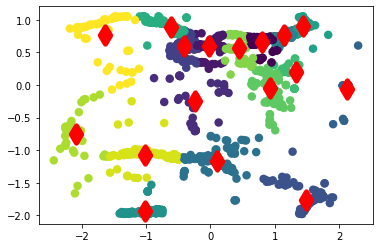

------------------------------
Mahalanobis Distance
O melhor K é: 17
O melhor DB_Index é: 0.62828
O melhor REC_ERROR é: 17.82827
------------------------------


In [36]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_pred, s=30, linewidths=3)
for centroid in best_mod.centroids:
    plt.scatter(centroid[0], centroid[1], marker="d", color="#FF0000", s=150, linewidths=5)
plt.show()

print("-" * 30)
print('Mahalanobis Distance')
print("O melhor K é: %i" % best_K)
print("O melhor DB_Index é: %.5f" % (db_index(X_, y_pred)))
print("O melhor REC_ERROR é: %.5f" % (rec_error(best_K, best_mod.centroids)))
print("-" * 30)

In [144]:
def PCA(comp_range, X, expl_variance=False):
    
    x_mean = X - np.mean(X, axis = 0)
    cov_m = np.cov(x_mean, rowvar = False)
    e_v, e_vec = np.linalg.eigh(cov_m)

    s_index = np.argsort(e_v)[::-1]
    s_e_nvalue = e_v[s_index]
    s_e_vectors = e_vec[:, s_index]

    print('Eigenvalues: \n', e_v)
    print("-" * 30)
    print('Eigenvectors: \n', e_vec)

    e_vec_s = s_e_vectors[:, 0:comp_range]
    xRed = np.dot(e_vec_s.transpose(), x_mean.transpose()).transpose()
    
    if expl_variance is True:
    
        eig_vals_total = sum(e_v)
        explained_variance = [(i / eig_vals_total)*100 for i in s_e_vectors]
        explained_variance = np.round(explained_variance, 2)
        cum_explained_variance = np.cumsum(explained_variance)

        print('Explained variance: {}'.format(explained_variance))
        print('Cumulative explained variance: {}'.format(cum_explained_variance))

        plt.plot(np.arange(1,5), cum_explained_variance, '-o')
        plt.xticks(np.arange(1,5))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance');
        plt.show()
    
    return xRed

Eigenvalues: 
 [0.10820954 0.36975289 0.7804609  2.75362487]
------------------------------
Eigenvectors: 
 [[ 0.14516955  0.64249509  0.6001949  -0.45375317]
 [-0.1599044  -0.42580043  0.79616951  0.39904723]
 [-0.78198369 -0.23609516  0.00578817 -0.576825  ]
 [ 0.58468615 -0.59173738  0.07646366 -0.54967471]]


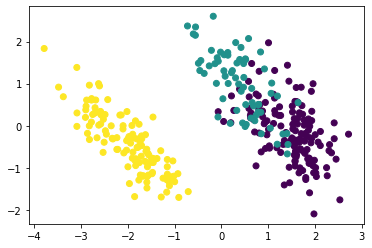

In [145]:
peng = np.genfromtxt('./penguins.csv', delimiter=',')
feat = np.arange(4)
lab = 4

ds2 = Data(peng, feat, lab)
X = ds2.get_x_apply(func=stats.zscore)

X = PCA(2, X, expl_variance=False)

plt.scatter(X[:, 0], X[:, 1], c=ds2.get_y())
plt.show()

Eigenvalues: 
 [0.7804609  2.75362487]
------------------------------
Eigenvectors: 
 [[-2.37694958e-16 -1.00000000e+00]
 [-1.00000000e+00  2.37694958e-16]]
Explained variance: [[-28.3  -0. ]
 [  0.  -28.3]]
Cumulative explained variance: [-28.3 -28.3 -28.3 -56.6]


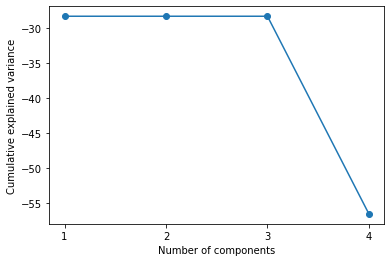

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [146]:
for i in range(1,5):
    X = PCA(i, X, expl_variance=True)